<a href="https://colab.research.google.com/github/jhancock75/Airfare_Prediction/blob/main/airfare_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airfare Prediction
## By Jake Hancock

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from re import sub
from decimal import Decimal
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Airfares.csv to Airfares.csv


In [ ]:
df = pd.read_csv('Airfares.csv')
df

,S_CODE,S_CITY,E_CODE,E_CITY,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE,Unnamed: 18
0,*,Dallas/Fort Worth TX,*,Amarillo TX,1.00,3,No,Yes,5291.99,"$28,637","$21,112",3036732,205711,Free,Free,312,7864,$64.11,NaN
1,*,Atlanta GA,*,Baltimore/Wash Intl MD,1.06,3,No,No,5419.16,"$26,993","$29,838",3532657,7145897,Free,Free,576,8820,$174.47,NaN
2,*,Boston MA,*,Baltimore/Wash Intl MD,1.06,3,No,No,9185.28,"$30,124","$29,838",5787293,7145897,Free,Free,364,6452,$207.76,NaN
3,ORD,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,"$29,260","$29,838",7830332,7145897,Controlled,Free,612,25144,$85.47,NaN
4,MDW,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,"$29,260","$29,838",7830332,7145897,Free,Free,612,25144,$85.47,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,LGA,New York/Newark NY,*,West Palm Beach FL,1.08,3,Yes,No,2216.70,"$32,991","$37,375",8621121,991717,Controlled,Free,1030,34324,$129.63,NaN
634,EWR,New York/Newark NY,*,West Palm Beach FL,1.08,0,Yes,No,2216.70,"$32,991","$37,375",8621121,991717,Free,Constrained,1030,34324,$129.63,NaN
635,*,Philadelphia/Camden PA,*,West Palm Beach FL,1.17,3,Yes,No,6797.80,"$27,994","$37,375",4948339,991717,Free,Free,960,6016,$124.87,NaN
636,IAD,Washington DC,*,West Palm Beach FL,1.28,3,Yes,No,5566.43,"$31,981","$37,375",4549784,991717,Free,Free,858,4877,$129.62,NaN


"Unnamed: 18" column made for some reason, even though not in original data set, decided to drop it.

In [ ]:
df = df.drop(columns=['Unnamed: 18'])
df

,S_CODE,S_CITY,E_CODE,E_CITY,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,*,Dallas/Fort Worth TX,*,Amarillo TX,1.00,3,No,Yes,5291.99,"$28,637","$21,112",3036732,205711,Free,Free,312,7864,$64.11
1,*,Atlanta GA,*,Baltimore/Wash Intl MD,1.06,3,No,No,5419.16,"$26,993","$29,838",3532657,7145897,Free,Free,576,8820,$174.47
2,*,Boston MA,*,Baltimore/Wash Intl MD,1.06,3,No,No,9185.28,"$30,124","$29,838",5787293,7145897,Free,Free,364,6452,$207.76
3,ORD,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,"$29,260","$29,838",7830332,7145897,Controlled,Free,612,25144,$85.47
4,MDW,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,"$29,260","$29,838",7830332,7145897,Free,Free,612,25144,$85.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,LGA,New York/Newark NY,*,West Palm Beach FL,1.08,3,Yes,No,2216.70,"$32,991","$37,375",8621121,991717,Controlled,Free,1030,34324,$129.63
634,EWR,New York/Newark NY,*,West Palm Beach FL,1.08,0,Yes,No,2216.70,"$32,991","$37,375",8621121,991717,Free,Constrained,1030,34324,$129.63
635,*,Philadelphia/Camden PA,*,West Palm Beach FL,1.17,3,Yes,No,6797.80,"$27,994","$37,375",4948339,991717,Free,Free,960,6016,$124.87
636,IAD,Washington DC,*,West Palm Beach FL,1.28,3,Yes,No,5566.43,"$31,981","$37,375",4549784,991717,Free,Free,858,4877,$129.62


Check for any null or missing values.

In [ ]:
df.isnull().sum()

S_CODE      0
S_CITY      0
E_CODE      0
E_CITY      0
COUPON      0
NEW         0
VACATION    0
SW          0
HI          0
S_INCOME    0
E_INCOME    0
S_POP       0
E_POP       0
SLOT        0
GATE        0
DISTANCE    0
PAX         0
FARE        0
dtype: int64

In [ ]:
df.isna().sum()

S_CODE      0
S_CITY      0
E_CODE      0
E_CITY      0
COUPON      0
NEW         0
VACATION    0
SW          0
HI          0
S_INCOME    0
E_INCOME    0
S_POP       0
E_POP       0
SLOT        0
GATE        0
DISTANCE    0
PAX         0
FARE        0
dtype: int64

There are no missing or null values

Need to convert currency to float values in order to be able to plot values.

In [ ]:
df[df.columns[np.r_[9:11,17]]] = df[df.columns[np.r_[9:11,17]]].replace('[\$,]', '', regex=True).astype(float)
df

,S_CODE,S_CITY,E_CODE,E_CITY,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,*,Dallas/Fort Worth TX,*,Amarillo TX,1.00,3,No,Yes,5291.99,28637.0,21112.0,3036732,205711,Free,Free,312,7864,64.11
1,*,Atlanta GA,*,Baltimore/Wash Intl MD,1.06,3,No,No,5419.16,26993.0,29838.0,3532657,7145897,Free,Free,576,8820,174.47
2,*,Boston MA,*,Baltimore/Wash Intl MD,1.06,3,No,No,9185.28,30124.0,29838.0,5787293,7145897,Free,Free,364,6452,207.76
3,ORD,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Controlled,Free,612,25144,85.47
4,MDW,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Free,Free,612,25144,85.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,LGA,New York/Newark NY,*,West Palm Beach FL,1.08,3,Yes,No,2216.70,32991.0,37375.0,8621121,991717,Controlled,Free,1030,34324,129.63
634,EWR,New York/Newark NY,*,West Palm Beach FL,1.08,0,Yes,No,2216.70,32991.0,37375.0,8621121,991717,Free,Constrained,1030,34324,129.63
635,*,Philadelphia/Camden PA,*,West Palm Beach FL,1.17,3,Yes,No,6797.80,27994.0,37375.0,4948339,991717,Free,Free,960,6016,124.87
636,IAD,Washington DC,*,West Palm Beach FL,1.28,3,Yes,No,5566.43,31981.0,37375.0,4549784,991717,Free,Free,858,4877,129.62


Create correlation plot to determine important features in predicting fare price.

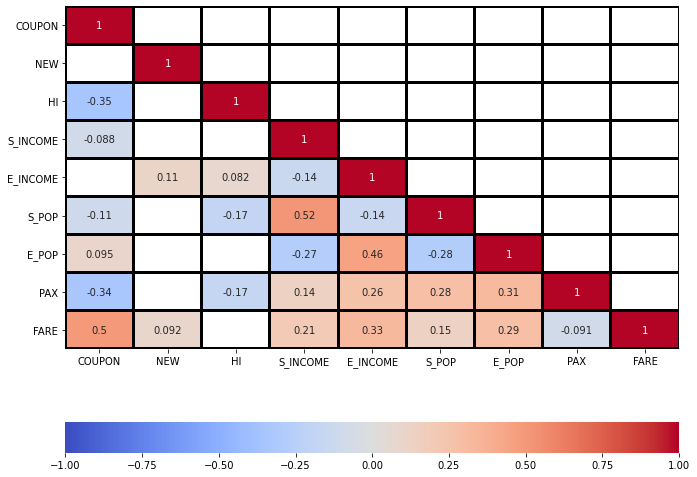

In [ ]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})
  
corr = df.iloc[:,np.r_[4:6,8:13,16:18]].corr()                        
p_values = corr_sig(df.iloc[:,np.r_[4:6,8:13,16:18]])                     
mask = np.invert(np.tril(p_values<0.05))    
plot_cor_matrix(corr,mask)  

## This plot leaves out correlations that have a p-value of less than 0.05 ##

The best single predictor of FARE appears to be coupon (correlation of 0.5 out of 1).

Create dummy variables for selected categorical variables.

In [ ]:
df_dummy = df
cat_vars = ['VACATION','SW','SLOT','GATE']
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_dummy[var], prefix=var)
    df_dummy = df_dummy.join(cat_list)
    

data_vars = df_dummy.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]
df_dummy = df_dummy.drop(['S_CODE','S_CITY','E_CODE','E_CITY','VACATION','SW','SLOT','GATE'], axis=1)
df_dummy

,COUPON,NEW,HI,S_INCOME,E_INCOME,S_POP,E_POP,DISTANCE,PAX,FARE,VACATION_No,VACATION_Yes,SW_No,SW_Yes,SLOT_Controlled,SLOT_Free,GATE_Constrained,GATE_Free
0,1.00,3,5291.99,28637.0,21112.0,3036732,205711,312,7864,64.11,1,0,0,1,0,1,0,1
1,1.06,3,5419.16,26993.0,29838.0,3532657,7145897,576,8820,174.47,1,0,1,0,0,1,0,1
2,1.06,3,9185.28,30124.0,29838.0,5787293,7145897,364,6452,207.76,1,0,1,0,0,1,0,1
3,1.06,3,2657.35,29260.0,29838.0,7830332,7145897,612,25144,85.47,1,0,0,1,1,0,0,1
4,1.06,3,2657.35,29260.0,29838.0,7830332,7145897,612,25144,85.47,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,1.08,3,2216.70,32991.0,37375.0,8621121,991717,1030,34324,129.63,0,1,1,0,1,0,0,1
634,1.08,0,2216.70,32991.0,37375.0,8621121,991717,1030,34324,129.63,0,1,1,0,0,1,1,0
635,1.17,3,6797.80,27994.0,37375.0,4948339,991717,960,6016,124.87,0,1,1,0,0,1,0,1
636,1.28,3,5566.43,31981.0,37375.0,4549784,991717,858,4877,129.62,0,1,1,0,0,1,0,1


Split data into train/test sets (60% train, 40% test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dummy.values[:,np.r_[0:9,10:18]],
    df_dummy.values[:,-9],
    test_size=0.40,
    random_state=101)

y_train = y_train.ravel()
y_test = y_test.ravel()

print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (382, 17) (382,)
Testing dataset shape: (256, 17) (256,)


Linear regression fit to assist with feature selection.

In [ ]:
# Step forward feature selection

forward_selection = SequentialFeatureSelector(LinearRegression(),
           k_features=5, # Choosing 5 features to start
           forward=True, # Forward selection
           floating=False, # Allows for larger number of feature subsets to be sampled
           verbose=2,
           scoring='neg_mean_absolute_error', # MAE good for continuous variable prediction
           cv=5) # 5-fold cross-validation

# Perform forward selection

forward_selection = forward_selection.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2021-02-22 16:30:39] Features: 1/5 -- score: -48.233318355850166[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2021-02-22 16:30:39] Features: 2/5 -- score: -38.35757074946932[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished

[2021-02-22 16:30:39] Features: 3/5 -- score: -33.45236508679594[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1

In [ ]:
feat_cols = list(forward_selection.k_feature_idx_)
feat_cols # Columns picked by model
# df_dummy.columns[9] is FARE which is the dependent variable
# The reason why the 9th column is listed as a feature here is because it is the 9th column from the X matrix, or df_dummy.columns[9+1] 

[2, 7, 9, 11, 16]

In [ ]:
print('Variables used:', df_dummy.columns[2], ',', df_dummy.columns[7], ',', df_dummy.columns[9+1], ',', df_dummy.columns[11+1], ',', df_dummy.columns[16+1])

Variables used: HI , DISTANCE , VACATION_No , SW_No , GATE_Free


In [ ]:
# Build full model with selected features
from sklearn.metrics import mean_squared_error
regression = LinearRegression()
regression.fit(X = X_train[:, feat_cols], y = y_train)

y_train_pred = regression.predict(X_train[:, feat_cols])
print('Training MAE on selected features: %.3f' % mean_absolute_error(y_train, y_train_pred))

y_test_pred = regression.predict(X_test[:, feat_cols])
print('Testing MAE on selected features: %.3f' % mean_absolute_error(y_test, y_test_pred))

print('Testing RMSE on selected features: %.3f' % mean_squared_error(y_test, y_test_pred))
print('Testing RMSE on selected features: %.3f' % mean_squared_error(y_test, y_test_pred))

print('Model coefficients:', regression.coef_, 'and intercept', regression.intercept_)

Training MAE on selected features: 29.919
Testing MAE on selected features: 30.384
Testing RMSE on selected features: 1504.287
Testing RMSE on selected features: 1504.287
Model coefficients: [ 7.33774045e-03  7.81942251e-02  5.11492553e+01  5.54770313e+01
 -2.19653650e+01] and intercept -7.775994600925628


Test model with 10 features allowed (previous had only 5)

In [ ]:
# Step forward feature selection

forward_selection = SequentialFeatureSelector(LinearRegression(),
           k_features=10, # Trying 10 features to compare to previous model
           forward=True, # Forward selection
           floating=False, # Allows for larger number of feature subsets to be sampled
           verbose=2,
           scoring='neg_mean_absolute_error', # MAE good for continuous variable prediction
           cv=5) # 5-fold cross-validation

# Perform forward selection

forward_selection = forward_selection.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2021-02-22 16:30:43] Features: 1/10 -- score: -48.233318355850166[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2021-02-22 16:30:43] Features: 2/10 -- score: -38.35757074946932[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished

[2021-02-22 16:30:43] Features: 3/10 -- score: -33.45236508679594[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

In [ ]:
feat_cols = list(forward_selection.k_feature_idx_)
feat_cols

[2, 4, 5, 6, 7, 8, 9, 11, 14, 16]

In [ ]:
print('Variables used:', df_dummy.columns[2], ',', df_dummy.columns[4], ',', df_dummy.columns[5], ',', df_dummy.columns[6], ',', df_dummy.columns[7], ',', df_dummy.columns[8], ',', df_dummy.columns[9+1], ',', df_dummy.columns[11+1], ',', df_dummy.columns[14+1], ',', df_dummy.columns[16+1])

Variables used: HI , E_INCOME , S_POP , E_POP , DISTANCE , PAX , VACATION_No , SW_No , SLOT_Free , GATE_Free


In [ ]:
# Build full model with selected features
from sklearn.metrics import mean_absolute_error

regression = LinearRegression()
regression.fit(X = X_train[:, feat_cols], y = y_train)

y_train_pred = regression.predict(X_train[:, feat_cols])
print('Training MAE on selected features: %.3f' % mean_absolute_error(y_train, y_train_pred))

y_test_pred = regression.predict(X_test[:, feat_cols])
print('Testing MAE on selected features: %.3f' % mean_absolute_error(y_test, y_test_pred))

print('Testing RMSE on selected features: %.3f' % mean_squared_error(y_test, y_test_pred))
print('Testing RMSE on selected features: %.3f' % mean_squared_error(y_test, y_test_pred))

print('Model coefficients:', regression.coef_, 'and intercept', regression.intercept_)

Training MAE on selected features: 28.051
Testing MAE on selected features: 26.840
Testing RMSE on selected features: 1262.107
Testing RMSE on selected features: 1262.107
Model coefficients: [ 8.82700059e-03  1.29995880e-03  4.37723387e-06  3.95956916e-06
  7.52904114e-02 -7.64118628e-04  3.72356893e+01  4.45196620e+01
 -1.29865874e+01 -2.18592002e+01] and intercept -43.45751108974761


Create dummy variables for ALL categorical variables.

In [ ]:
df_dummy_all = df
cat_vars = ['S_CODE','S_CITY','E_CODE','E_CITY','VACATION','SW','SLOT','GATE']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_dummy_all[var], prefix=var)
    df_dummy_all = df_dummy_all.join(cat_list)
    

data_vars = df_dummy_all.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
df_dummy_all = df_dummy_all.drop(['S_CODE','S_CITY','E_CODE','E_CITY','VACATION','SW','SLOT','GATE'], axis=1)
df_dummy_all

,COUPON,NEW,HI,S_INCOME,E_INCOME,S_POP,E_POP,DISTANCE,PAX,FARE,S_CODE_*,S_CODE_DCA,S_CODE_EWR,S_CODE_IAD,S_CODE_JFK,S_CODE_LGA,S_CODE_MDW,S_CODE_ORD,S_CITY_Albuquerque NM,S_CITY_Anchorage AK,S_CITY_Atlanta GA,S_CITY_Austin TX,S_CITY_Baltimore/Wash Intl MD,S_CITY_Boise ID,S_CITY_Boston MA,S_CITY_Burbank CA,S_CITY_Chicago IL,S_CITY_Cincinnati OH,S_CITY_Cleveland OH,S_CITY_Columbus OH,S_CITY_Corpus Christi TX,S_CITY_Dallas/Fort Worth TX,S_CITY_Denver CO,S_CITY_Detroit MI,S_CITY_El Paso TX,S_CITY_Fort Lauderdale FL,S_CITY_Fort Meyers FL,S_CITY_Greenville/Sprtnbg SC,S_CITY_Hartford CT,S_CITY_Honolulu (Intl) HI,...,E_CITY_New Orleans LA,E_CITY_New York/Newark NY,E_CITY_Oakland CA,E_CITY_Oklahoma City OK,E_CITY_Omaha NE,E_CITY_Orlando FL,E_CITY_Philadelphia/Camden PA,E_CITY_Phoenix AZ,E_CITY_Pittsburgh PA,E_CITY_Portland OR,E_CITY_Providence RI,E_CITY_Raleigh/Durham NC,E_CITY_Reno NV,E_CITY_Richmond (Intl) VA,E_CITY_Rochester NY,E_CITY_Sacramento CA,E_CITY_Salt Lake City UT,E_CITY_San Antonio TX,E_CITY_San Diego CA,E_CITY_San Francisco CA,E_CITY_San Jose CA,E_CITY_Sarasota/Bradenton FL,E_CITY_Seattle/Tacoma WA,E_CITY_Spokane WA,E_CITY_St Louis MO,E_CITY_Syracuse NY,E_CITY_Tallahassee FL,E_CITY_Tampa FL,E_CITY_Tucson AZ,E_CITY_Tulsa OK,E_CITY_Washington DC,E_CITY_West Palm Beach FL,VACATION_No,VACATION_Yes,SW_No,SW_Yes,SLOT_Controlled,SLOT_Free,GATE_Constrained,GATE_Free
0,1.00,3,5291.99,28637.0,21112.0,3036732,205711,312,7864,64.11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1
1,1.06,3,5419.16,26993.0,29838.0,3532657,7145897,576,8820,174.47,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1
2,1.06,3,9185.28,30124.0,29838.0,5787293,7145897,364,6452,207.76,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1
3,1.06,3,2657.35,29260.0,29838.0,7830332,7145897,612,25144,85.47,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1
4,1.06,3,2657.35,29260.0,29838.0,7830332,7145897,612,25144,85.47,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,1.08,3,2216.70,32991.0,37375.0,8621121,991717,1030,34324,129.63,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1
634,1.08,0,2216.70,32991.0,37375.0,8621121,991717,1030,34324,129.63,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0
635,1.17,3,6797.80,27994.0,37375.0,4948339,991717,960,6016,124.87,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1
636,1.28,3,5566.43,31981.0,37375.0,4549784,991717,858,4877,129.62,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1


Split set into training and test sets again.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dummy_all.values[:,np.r_[0:9,10:153]],
    df_dummy_all.values[:,9],
    test_size=0.40,
    random_state=101)

y_train = y_train.ravel()
y_test = y_test.ravel()

print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (382, 152) (382,)
Testing dataset shape: (256, 152) (256,)


In [ ]:
# Step forward feature selection

forward_selection = SequentialFeatureSelector(LinearRegression(),
           k_features=5, # Choosing 5 features to start
           forward=True, # Forward selection
           floating=False, # Allows for larger number of feature subsets to be sampled
           verbose=2,
           scoring='neg_mean_absolute_error', # MAE good for continuous variable prediction
           cv=5) # 5-fold cross-validation

# Perform forward selection

forward_selection = forward_selection.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:    0.7s finished

[2021-02-22 16:30:49] Features: 1/5 -- score: -48.233318355850166[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:    0.7s finished

[2021-02-22 16:30:50] Features: 2/5 -- score: -38.35757074946932[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished

[2021-02-22 16:30:51] Features: 3/5 -- score: -33.45236508679594[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1

In [ ]:
feat_cols = list(forward_selection.k_feature_idx_)
feat_cols # Columns picked by model

[2, 7, 9, 144, 146]

In [ ]:
print('Variables used:', df_dummy_all.columns[2], ',', df_dummy_all.columns[7], ',', df_dummy_all.columns[9+1], ',', df_dummy_all.columns[144+1], ',', df_dummy_all.columns[146+1])

Variables used: HI , DISTANCE , S_CODE_* , VACATION_No , SW_No


In [ ]:
# Build full model with selected features
from sklearn.metrics import mean_absolute_error

regression = LinearRegression()
regression.fit(X = X_train[:, feat_cols], y = y_train)

y_train_pred = regression.predict(X_train[:, feat_cols])
print('Training MAE on selected features: %.3f' % mean_absolute_error(y_train, y_train_pred))

y_test_pred = regression.predict(X_test[:, feat_cols])
print('Testing MAE on selected features: %.3f' % mean_absolute_error(y_test, y_test_pred))

print('Testing RMSE on selected features: %.3f' % mean_squared_error(y_test, y_test_pred))
print('Testing RMSE on selected features: %.3f' % mean_squared_error(y_test, y_test_pred))

print('Model coefficients:', regression.coef_, 'and intercept', regression.intercept_)

Training MAE on selected features: 29.830
Testing MAE on selected features: 30.205
Testing RMSE on selected features: 1536.188
Testing RMSE on selected features: 1536.188
Model coefficients: [ 1.03664937e-02  8.09779883e-02 -2.35265100e+01  4.87824049e+01
  5.69436008e+01] and intercept -24.438078206127614


Just as with initial model, experiment with 10 features allowed now as opposed to just 5

In [ ]:
# Step forward feature selection

forward_selection = SequentialFeatureSelector(LinearRegression(),
           k_features=10, # Choosing 10 features now
           forward=True, # Forward selection
           floating=False, # Allows for larger number of feature subsets to be sampled
           verbose=2,
           scoring='neg_mean_absolute_error', # MAE good for continuous variable prediction
           cv=5) # 5-fold cross-validation

# Perform forward selection

forward_selection = forward_selection.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:    0.7s finished

[2021-02-22 16:31:01] Features: 1/10 -- score: -48.233318355850166[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:    0.7s finished

[2021-02-22 16:31:01] Features: 2/10 -- score: -38.35757074946932[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished

[2021-02-22 16:31:02] Features: 3/10 -- score: -33.45236508679594[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

In [ ]:
feat_cols = list(forward_selection.k_feature_idx_)
feat_cols # Columns picked by model

[2, 7, 8, 9, 30, 68, 87, 144, 146, 150]

In [ ]:
print('Variables used:', df_dummy_all.columns[2], ',', df_dummy_all.columns[7], ',', df_dummy_all.columns[8], ',', df_dummy_all.columns[9+1], ',', df_dummy_all.columns[30+1], ',', 
      df_dummy_all.columns[68+1], ',', df_dummy_all.columns[87+1], ',', df_dummy_all.columns[144+1], ',', df_dummy_all.columns[146+1], ',', df_dummy_all.columns[150+1])

Variables used: HI , DISTANCE , PAX , S_CODE_* , S_CITY_Dallas/Fort Worth   TX , E_CODE_* , E_CITY_Colorado Springs    CO , VACATION_No , SW_No , GATE_Constrained


In [ ]:
# Build full model with selected features
from sklearn.metrics import mean_absolute_error

regression = LinearRegression()
regression.fit(X = X_train[:, feat_cols], y = y_train)

y_train_pred = regression.predict(X_train[:, feat_cols])
print('Training MAE on selected features: %.3f' % mean_absolute_error(y_train, y_train_pred))

y_test_pred = regression.predict(X_test[:, feat_cols])
print('Testing MAE on selected features: %.3f' % mean_absolute_error(y_test, y_test_pred))

print('Training RMSE on selected features: %.3f' % mean_squared_error(y_test, y_test_pred))
print('Testing RMSE on selected features: %.3f' % mean_squared_error(y_test, y_test_pred))

print('Model coefficients:', regression.coef_, 'and intercept', regression.intercept_)

Training MAE on selected features: 26.318
Testing MAE on selected features: 27.470
Training RMSE on selected features: 1328.681
Testing RMSE on selected features: 1328.681
Model coefficients: [ 9.04550425e-03  8.19915731e-02 -5.73634303e-04 -3.75688192e+01
  4.40710743e+01 -3.43759762e+01 -7.15943158e+01  4.20377578e+01
  4.06881520e+01  2.31465298e+01] and intercept 34.777078244152236


The best model (smallest testing MAE and RMSE values) is a linear regression with 10 features selected using the dummy set not containing the first 4 categorical variable dummy set:
- Training MAE: 28.051
- Testing MAE: 26.840
- Training RMSE: 1262.107
- Testing RMSE: 1262.107

The coefficients for this model are:
- [ 8.82700059e-03  1.29995880e-03  4.37723387e-06  3.95956916e-06
  7.52904114e-02 -7.64118628e-04  3.72356893e+01  4.45196620e+01
 -1.29865874e+01 -2.18592002e+01]

The intercept for this model is:
- -43.45751108974761

Compare the MAE and RMSE values to the FARE distribution in order to determine how effective the most optimal model is:

In [ ]:
df['FARE'].describe()

count    638.000000
mean     160.876677
std       76.022436
min       42.470000
25%      106.290000
50%      144.600000
75%      209.350000
max      402.020000
Name: FARE, dtype: float64

Having a test MAE of 26.84 dollars while the standard deviation for fares is 76.02 dollars is a very good sign as the average prediction error falls within this deviation. Unfortunately, the RMSE values for both of the model results for training and test sets are very high with a minimum value found in the most optimal model (RMSE = 1262.107 dollars while the mean, minimum, and maximum values for FARES are 160.88 dollars, 42.47 dollars, and 402.02 dollars, respectively).

Prediction accuracy could potentially be improved through the use of a more robust regression model, such as ridge or lasso regression, due to the effectiveness in handling outliers and noise.